In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import random, jit, value_and_grad, lax, partial, nn, vmap, device_count, pmap
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp

from jax.experimental import optimizers

from util import progress_bar_scan, wait_until_computed, init_params, set_host_device_count

set_host_device_count(10)

from tqdm.auto import tqdm


print(f"Number of devices: {device_count()}")

Number of devices: 10


# Jitting loops, progress_bar, and vmap/pmap


Overview:

1. `lax.scan` vs a python loop
2. Progress bar for jitted loops
3. Using vmap and pmap for `lax.scan`

Examples: 
- 1D MoG
- 5D logistic regression
- Neural Network training


Relevant blog posts:
- My [blog post](https://www.jeremiecoullon.com/2020/11/10/mcmcjax3ways/) about writing samplers in JAX (with benchmarks on CPU and GPU)
- Another [blog post](https://www.jeremiecoullon.com/2021/01/29/jax_progress_bar/) about adding a progress bar to jitted loops in JAX 

# 1. `lax.scan` vs a python loop


#### A simple example of `lax.scan`: 

a loop that increments the argument a given number of times

In [2]:
def myloop(x, Niter):
    
    for i in range(Niter):
        x += 1
    return x

In [5]:
myloop(4., 40)

44.0

In [14]:
# @jit
@partial(jit, static_argnums=(1,))
def myscan(x, Niter):
    
    def body(carry, idx):
        return carry+1, None
    
    return lax.scan(body, x, jnp.arange(Niter))[0]

In [15]:
myscan(0., 10)

DeviceArray(10., dtype=float32)

#### Jax is asynchronous

In [25]:
%time myscan(0., 100000000)

CPU times: user 270 µs, sys: 98 µs, total: 368 µs
Wall time: 232 µs


Buffer(16777216., dtype=float32)

In [26]:
%time myscan(0., 100000000).block_until_ready()

CPU times: user 255 ms, sys: 3.85 ms, total: 259 ms
Wall time: 261 ms


Buffer(16777216., dtype=float32)

In [27]:
from jax.tree_util import tree_leaves

def wait_until_computed(x):
    for leaf in tree_leaves(x):
        leaf.block_until_ready()

In [28]:
%time wait_until_computed(myscan(0., 100000000))

CPU times: user 250 ms, sys: 2.7 ms, total: 253 ms
Wall time: 256 ms


In [22]:
# %time wait_until_computed([myscan(0., 100000000), myscan(0., 100000000),myscan(0., 100000000)])

CPU times: user 740 ms, sys: 6.86 ms, total: 747 ms
Wall time: 753 ms


## Let's write a MALA sampler in JAX


#### First, define a MoG posterior: 

- posterior code is from [Massively parallel MCMC with Jax](https://rlouf.github.io/post/jax-random-walk-metropolis/) by Remi Louf

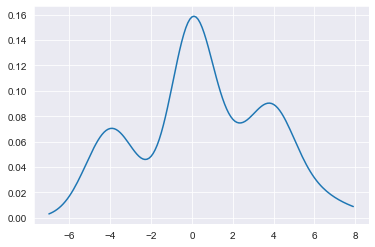

In [29]:
def mixture_logpdf(x):
    """Log probability distribution function of a gaussian mixture model.
    Attribute
    ---------
    x: np.ndarray (4,)
        Position at which to evaluate the probability density function.
    Returns
    -------
    float
        The value of the log probability density function at x.
    """
    dist_1 = partial(norm.logpdf, loc=-4.0, scale=1.2)
    dist_2 = partial(norm.logpdf, loc=0, scale=1)
    dist_3 = partial(norm.logpdf, loc=4., scale=1)
    dist_4 = partial(norm.logpdf, loc=2.5, scale=2.8)
    log_probs = jnp.array([dist_1(x), dist_2(x), dist_3(x), dist_4(x)])
    weights = jnp.array([0.2, 0.3, 0.1, 0.4])
    return logsumexp(jnp.log(weights) + log_probs)


batch_logpdf = vmap(mixture_logpdf)

x_range = np.arange(-7.,8,0.1)
plt.plot(x_range, np.exp(batch_logpdf(x_range)))

#### MALA update function

This is the transition kernel: takes in the current sampler and log-posterior function and returns the new parameter

In [30]:
@partial(jit, static_argnums=(3,))
def mala_kernel(key, paramCurrent, paramGradCurrent, log_post, logpostCurrent, dt):
    dim = paramCurrent.shape[0]
    subkey1, subkey2 = random.split(key)
    paramProp = paramCurrent + dt*paramGradCurrent + jnp.sqrt(2*dt)*random.normal(key=subkey1, shape=(dim,))
    new_log_post, new_grad = log_post(paramProp)

    term1 = paramProp - paramCurrent - dt*paramGradCurrent
    term2 = paramCurrent - paramProp - dt*new_grad
    q_new = -0.25*(1/dt)*jnp.dot(term1, term1)
    q_current = -0.25*(1/dt)*jnp.dot(term2, term2)

    log_ratio = new_log_post - logpostCurrent + q_current - q_new
    acceptBool = jnp.log(random.uniform(key=subkey2)) < log_ratio
    paramCurrent = jnp.where(acceptBool, paramProp, paramCurrent)
    current_grad = jnp.where(acceptBool, new_grad, paramGradCurrent)
    current_log_post = jnp.where(acceptBool, new_log_post, logpostCurrent)
    accepts_add = jnp.where(acceptBool, 1,0)
    return paramCurrent, current_grad, current_log_post, accepts_add



#### Sampler 1: a python loop

In [31]:
def mala_sampler_python(key, num_samples, dt, val_and_grad_log_post, x_0):
    dim, = x_0.shape
    samples = np.zeros((num_samples, dim))
    paramCurrent = x_0
    accepts = 0
    current_log_post, current_grad = val_and_grad_log_post(paramCurrent)
    
    for i in tqdm(range(num_samples)):
        key, subkey = random.split(key)
        paramCurrent, current_grad, current_log_post, accepts_add = mala_kernel(subkey,
                                                                        paramCurrent,
                                                                        current_grad,
                                                                        val_and_grad_log_post,
                                                                        current_log_post,
                                                                        dt)
        accepts += accepts_add
        samples[i] = paramCurrent
    accept_rate = accepts/num_samples * 100
    print(f"Acceptance rate: {accept_rate:.1f}%")
    return samples

In [32]:
key = random.PRNGKey(0)
num_samples = 10000
dt = 4.
x_0 = jnp.array([0.])

starttime = time.time()
samples_py = mala_sampler_python(key, num_samples, dt, value_and_grad(mixture_logpdf), x_0)


endtime = time.time()

print(f"Sampled {num_samples:,} samples in {endtime-starttime:.1f} seconds")


Acceptance rate: 61.4%
Sampled 10,000 samples in 5.1 seconds


In [33]:
def mala_sampler(key, num_samples, dt, val_and_grad_log_post, x_0):
    
    def mala_step(carry, x):
        key, paramCurrent, gradCurrent, logpostCurrent, accepts = carry
        key, subkey = random.split(key)
        paramCurrent, gradCurrent, logpostCurrent, accepts_add = mala_kernel(subkey, paramCurrent, gradCurrent, val_and_grad_log_post, logpostCurrent, dt)
        accepts += accepts_add
        return (key, paramCurrent, gradCurrent, logpostCurrent, accepts), (paramCurrent, gradCurrent)

    paramCurrent = x_0
    logpostCurrent, gradCurrent = val_and_grad_log_post(x_0)
    carry = (key, paramCurrent, gradCurrent, logpostCurrent, 0)
    
    (_, _, _, _, accepts), (samples, grads) = lax.scan(mala_step, carry, jnp.arange(num_samples))
    
    return samples, grads, 100*(accepts/num_samples)


In [37]:
key = random.PRNGKey(0)
num_samples = 10000000
dt = 4.
x_0 = jnp.array([0.])

starttime = time.time()

samples_scan, _, _ = mala_sampler(key, num_samples, dt, 
                           value_and_grad(mixture_logpdf), jnp.array([0.]))

wait_until_computed(samples_scan)

endtime = time.time()

print(f"Sampled {num_samples:,} samples in {endtime-starttime:.1f} seconds")

Sampled 10,000,000 samples in 5.5 seconds


### conclusion:

for simple problems, `lax.scan` can be several orders of magnitude faster than a python loop

# 2. Progress bar for jitted loops


### `host_callback`


Side effects only run at compile time, so you can't simply print out a progress bar (or use `tqdm`)

In [42]:
@jit
def myfun(x):
    print("running a function")
    return x

In [47]:
myfun(3)

DeviceArray(3, dtype=int32)

In [48]:
from jax.experimental import host_callback

In [49]:
def _print_consumer(arg, transform):
    print(f"hello")

@jit
def myfun2(x):
    x = host_callback.id_tap(tap_func=_print_consumer, arg=x)
    return x
    

In [58]:
myfun2(623.)

Buffer(623., dtype=float32)

hello


### in a `lax.scan`

In [143]:
def _print_pbar(arg, transform):
    print(f"Iteration {arg[0]}/{arg[1]}")
    
    
@partial(jit, static_argnums=(1,))
def myscan_2(x, Niter):
    
    def body(carry, idx):
        carry = host_callback.id_tap(_print_pbar, arg=(idx, Niter), result=carry)
        return carry+1, None
    
    return lax.scan(body, x, jnp.arange(Niter))[0]

##### Note: 

python prints too slowly compared to Jax, so the order here is wrong..

In [144]:

myscan_2(2., 10)

Iteration 0/10
Iteration 1/10
Iteration 2/10

DeviceArray(12., dtype=float32)


Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10


### `tqdm`

Reminder of the usage of `tqdm` progress bar:



In [66]:
# Standard usage
mylist = []

for i in tqdm(range(10)):
    time.sleep(0.1)
    mylist.append(i)
    

In [72]:
# Manual usage
mylist = []

mypbar = tqdm(range(10))

for i in range(10):
    time.sleep(0.1)
    mylist.append(i)
    mypbar.update(1.5)
    
#     if i%2==0:
#         mypbar.update(4)

mypbar.close()

To use `tqdm` with `host_callback, we need to build a decorator that adds functionality to the `body` function in a `lax.scan` function. Namely:

1. Callback that defines the `tqdm` progress bar at the beginning of the scan
2. Callback that updates it every few iterations
3. Callback that closes the progress bar at the end



In [73]:
def progress_bar_scan(num_samples, message=None):
    "Progress bar for a JAX scan"
    if message is None:
            message = f"Running for {num_samples:,} iterations"
    tqdm_bars = {}

    if num_samples > 20:
        print_rate = int(num_samples / 20)
    else:
        print_rate = 1
    remainder = num_samples % print_rate

    def _define_tqdm(arg, transform):
        tqdm_bars[0] = tqdm(range(num_samples))
        tqdm_bars[0].set_description(message, refresh=False)

    def _update_tqdm(arg, transform):
        tqdm_bars[0].update(arg)

    def _update_progress_bar(iter_num):
        "Updates tqdm progress bar of a JAX scan or loop"
        _ = lax.cond(
            iter_num == 0,
            lambda _: host_callback.id_tap(_define_tqdm, None, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm every multiple of `print_rate` except at the end
            (iter_num % print_rate == 0) & (iter_num != num_samples-remainder),
            lambda _: host_callback.id_tap(_update_tqdm, print_rate, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm by `remainder`
            iter_num == num_samples-remainder,
            lambda _: host_callback.id_tap(_update_tqdm, remainder, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

    def _close_tqdm(arg, transform):
        tqdm_bars[0].close()

    def close_tqdm(result, iter_num):
        return lax.cond(
            iter_num == num_samples-1,
            lambda _: host_callback.id_tap(_close_tqdm, None, result=result),
            lambda _: result,
            operand=None,
        )


    def _progress_bar_scan(func):
        """Decorator that adds a progress bar to `body_fun` used in `lax.scan`.
        Note that `body_fun` must be looping over `np.arange(num_samples)`
        """

        def wrapper_progress_bar(carry, x):
            iter_num = x
            result = func(carry, x)
            _update_progress_bar(iter_num)
            return close_tqdm(result, iter_num)

        return wrapper_progress_bar

    return _progress_bar_scan


In [74]:

def mala_sampler(key, num_samples, dt, val_and_grad_log_post, x_0):
    
    @progress_bar_scan(num_samples)
    def mala_step(carry, x):
        key, paramCurrent, gradCurrent, logpostCurrent, accepts = carry
        key, subkey = random.split(key)
        paramCurrent, gradCurrent, logpostCurrent, accepts_add = mala_kernel(subkey, paramCurrent, gradCurrent, val_and_grad_log_post, logpostCurrent, dt)
        accepts += accepts_add
        return (key, paramCurrent, gradCurrent, logpostCurrent, accepts), (paramCurrent, gradCurrent)

    paramCurrent = x_0
    logpostCurrent, gradCurrent = val_and_grad_log_post(x_0)
    carry = (key, paramCurrent, gradCurrent, logpostCurrent, 0)
    
    (_, _, _, _, accepts), (samples, grads) = lax.scan(mala_step, carry, jnp.arange(num_samples))
    
    return samples, grads, 100*(accepts/num_samples)


In [79]:
key = random.PRNGKey(0)
num_samples = 1000000
dt = 4.
x_0 = jnp.array([0.])


samples_scan, _, _ = mala_sampler(key, num_samples, dt, 
                           value_and_grad(mixture_logpdf), jnp.array([0.]))

wait_until_computed(samples_scan)


# 3. vmap/pmap

### a simple function

In [80]:
def square(x):
    return x*x


vmap_square = vmap(square)
pmap_square = pmap(square)

In [85]:
x_range = jnp.arange(10)

vmap_square(x_range)

DeviceArray([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81], dtype=int32)

In [86]:
pmap_square(x_range)

ShardedDeviceArray([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81], dtype=int32)

### Note:

You must set the number of devices _before_ running any jax code (example `jnp.arange(10)`). Once you've run some jax code you it seems that youy can't change the number of devices anymore (at least not with `set_host_device_count(10)`):


```python

def set_host_device_count(n):
    """
    From Numpyro
    By default, XLA considers all CPU cores as one device. This utility tells XLA
    that there are `n` host (CPU) devices available to use. As a consequence, this
    allows parallel mapping in JAX :func:`jax.pmap` to work in CPU platform.

    .. note:: This utility only takes effect at the beginning of your program.
        Under the hood, this sets the environment variable
        `XLA_FLAGS=--xla_force_host_platform_device_count=[num_devices]`, where
        `[num_device]` is the desired number of CPU devices `n`.

    .. warning:: Our understanding of the side effects of using the
        `xla_force_host_platform_device_count` flag in XLA is incomplete. If you
        observe some strange phenomenon when using this utility, please let us
        know through our issue or forum page. More information is available in this
        `JAX issue <https://github.com/google/jax/issues/1408>`_.

    :param int n: number of CPU devices to use.
    """
    xla_flags = os.getenv('XLA_FLAGS', '').lstrip('--')
    xla_flags = re.sub(r'xla_force_host_platform_device_count=.+\s', '', xla_flags).split()
    os.environ['XLA_FLAGS'] = ' '.join(['--xla_force_host_platform_device_count={}'.format(n)]
                                       + xla_flags)
```

#### There's an error if you pmap over more elements than there are devices

In [89]:
# pmap_square(jnp.arange(12))

### Question:

what is a device? How does this work?

### Using vmap and pmap with `lax.scan`

In [90]:
@jit
def myscan(x):
    Niter = 10
    
    def body(carry, idx):
        return carry+1, None
    
    return lax.scan(body, x, jnp.arange(Niter))[0]

In [94]:
v_myscan = vmap(myscan, in_axes=(0,))
p_myscan = pmap(myscan, in_axes=(0,))

In [96]:
jnp.arange(10.)

DeviceArray([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [95]:
v_myscan(jnp.arange(10.))

DeviceArray([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=float32)

In [100]:
p_myscan(jnp.arange(10.))

ShardedDeviceArray([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=float32)

### Samplers in parallel

In [101]:
num_samples = 1000000
dt = 4.
x_0 = jnp.array([0.])

run_mala_sampler_base = partial(mala_sampler, num_samples=num_samples, dt=dt, 
                           val_and_grad_log_post=value_and_grad(mixture_logpdf), 
                           x_0=jnp.array([0.]))


In [103]:
starttime = time.time()

key = random.PRNGKey(0)
my_samples = run_mala_sampler_base(key)

wait_until_computed(my_samples)

print(f"Running time: {time.time()-starttime:.2f}sec")


Running time: 1.32sec



#### vmap the sampler

In [104]:
v_run_mala = vmap(run_mala_sampler_base)



In [105]:
Nensemble = 10
keys = random.split(key, Nensemble)

In [110]:
starttime = time.time()

Nensemble = 10
keys = random.split(key, Nensemble)

mysamples = jit(v_run_mala)(keys)
wait_until_computed(mysamples)

print(f"Running time: {time.time()-starttime:.2f}sec")


Running time: 2.37sec


In [111]:
mysamples[0].shape

(10, 1000000, 1)

#### pmap the sampler

_Note:_ we import another `mala_sampler` that has a progress_bar that works with `pmap`

In [141]:
from mala import mala_sampler as mala_sampler_par

run_mala_sampler_base_p = partial(mala_sampler_par, num_samples=num_samples, dt=dt, 
                           val_and_grad_log_post=value_and_grad(mixture_logpdf), 
                           x_0=jnp.array([0.]))

p_run_mala = pmap(partial(run_mala_sampler_base_p, num_chains=Nensemble))

In [142]:
starttime = time.time()

mysamples = p_run_mala(keys)
wait_until_computed(mysamples)

print(f"Running time: {time.time()-starttime:.2f}sec")

print(f"Number of samples: {np.prod(mysamples[0].shape):,}")



Running time: 0.88sec
Number of samples: 20,000


## Applications:



- Simply getting more MCMC samples for "free"
- pseudomarginal mcmc: annealed importance sampling inside MCMC to estimate the likelihood
- out of distribution testing for NN
- ensemble preconditioning

## Try it on Logistic regression: 5D with 10K data points

In [117]:
from logistic_regression import gen_data_and_log_post

In [119]:
key = random.PRNGKey(0)
dim = 5
N = 10000

theta_true, X_data_LR, y_data_LR, val_and_grad_log_post = gen_data_and_log_post(key, dim, N)

@jit
def log_regr_log_post(theta):
    return val_and_grad_log_post(theta, X_data_LR, y_data_LR)

generating data, with N=10000 and dim=5


In [121]:
key = random.PRNGKey(0)
num_samples = 10000
dt = 8e-4
x_0 = jnp.zeros(theta_true.shape)

run_mala_LR = partial(mala_sampler, num_samples=num_samples, dt=dt, 
                           val_and_grad_log_post=log_regr_log_post, 
                           x_0=x_0)


In [122]:
key = random.PRNGKey(0)

starttime = time.time()
samples, _, accept_rate = run_mala_LR(key)
print(f"Acceptance rate: {accept_rate:.1f}%\n")

print(f"Running time: {time.time()-starttime:.2f}sec")

print(f"Number of samples: {samples.shape[0]:,}")

Acceptance rate: 81.7%

Running time: 2.53sec
Number of samples: 10,000



In [123]:
Nensemble = 10
keys = random.split(key, Nensemble)


v_run_mala_LR = jit(vmap(partial(run_mala_LR)))


In [125]:

starttime = time.time()
v_samples = v_run_mala_LR(keys)
wait_until_computed(v_samples)

print(f"Running time: {time.time()-starttime:.2f}sec")

print(f"Number of samples: {np.prod((v_samples[0].shape)[:2]):,}")


Running time: 5.61sec
Number of samples: 100,000


`pmap`

In [126]:

run_mala_LR_p = partial(mala_sampler_par, num_samples=num_samples, dt=dt, 
                           val_and_grad_log_post=log_regr_log_post, 
                           x_0=x_0)
p_run_mala_LR = pmap(partial(run_mala_LR_p, num_chains=Nensemble))


In [129]:

starttime = time.time()


p_samples = p_run_mala_LR(keys)
wait_until_computed(p_samples)

print(f"Running time: {time.time()-starttime:.2f}sec")
print(f"Number of samples: {np.prod((p_samples[0].shape)[:2]):,}")

Running time: 3.35sec
Number of samples: 100,000


# Extra: Neural Network training


This seems to depend: sometimes vmap and pmap is fast, sometimes it's not


In [3]:
from MNIST_data import X_train, y_train, X_test, y_test

In [131]:
# model
def predict(params, x):
    
    activation = x
    
    for W,b in params[:-1]:
        activation = nn.relu(jnp.dot(W,activation) + b)
        
    W_last, b_last = params[-1]
    return nn.log_softmax(jnp.dot(W_last, activation) + b_last)

batch_predict = vmap(predict, in_axes=(None, 0))

def loss_NN(params, x_data, y_data):
    return -jnp.mean(jnp.sum(batch_predict(params, x_data)*y_data, axis=1))

@jit
def accuracy(params, X, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(batch_predict(params, X), axis=1)
    return jnp.mean(predicted_class == target_class)


In [132]:
from util import progress_bar_scan_parallel

In [133]:
def run_adam_single_NN(key, Niters, l_rate, batch_size, x_data, y_data, network_sizes, X_test, y_test, num_chains=1):
    Ndata = x_data.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(l_rate)
    
    def body(state, step):
        key, opt_state = state
        key, subkey = random.split(key)
        idx_batch = random.choice(key=subkey, a=jnp.arange(Ndata), shape=(batch_size,))
        _, loss_grad = value_and_grad(loss_NN)(get_params(opt_state), x_data[idx_batch,:], y_data[idx_batch,:])
        opt_state = opt_update(step, loss_grad, opt_state)
        return (key, opt_state), None
    
    key, subkey = random.split(key)
    M, D, K, L = network_sizes
    params_IC = init_params(subkey, M, D, K, L)
    state = (key, opt_init(params_IC))
    my_pbar = progress_bar_scan_parallel(Niters, num_chains)
    body = my_pbar(body)
    (_, opt_state), _ = lax.scan(body, state, jnp.arange(Niters))
    return get_params(opt_state)


In [134]:
Niters = 1000
M, L = 200, 2
Ndata, D = X_train.shape
K = y_train.shape[1]
network_sizes = (M, D, K, L)
l_rate = 1e-2
batch_size = 1000

train_NN = partial(run_adam_single_NN, Niters=Niters, l_rate=l_rate, 
                   batch_size=batch_size, x_data=X_train, y_data=y_train, 
                   network_sizes=network_sizes, X_test=X_test, y_test=y_test)


In [135]:
key = random.PRNGKey(0)

starttime = time.time()
wait_until_computed(train_NN(key))
print(f"Running time: {time.time()-starttime:.2f}sec")

Running time: 6.50sec



#### vmap and pmap

In [136]:
Nensemble = 2
keys = random.split(key, Nensemble)

v_train_NN = jit(vmap(partial(train_NN)))
p_train_NN = pmap(partial(train_NN, num_chains=Nensemble))

In [139]:
starttime = time.time()

wait_until_computed(v_train_NN(keys))

print(f"Running time: {time.time()-starttime:.2f}sec")

Running time: 8.54sec


In [138]:
starttime = time.time()

wait_until_computed(p_train_NN(keys))

print(f"Running time: {time.time()-starttime:.2f}sec")

Running time: 12.89sec


